# Tanzanian Waterwell Pump Analysis

## Overview

The people of Tanzania are facing a water crisis and Wells of Life is trying to help. Their goal is to repair water wells in Tanzania so that so that the citizens have water that is safe for drinking and hygiene needs. The goal of this notebook is to produce a strong classification model that can accurately classify the functionality of wells in Tanzania. 

## Overview

The people of Tanzania are facing a water crisis and Wells of Life is trying to help. Their goal is to repair water wells in Tanzania so that so that the citizens have water that is safe for drinking and hygiene needs. The goal of this notebook is to produce a strong classification model that can accurately classify the functionality of wells in Tanzania. 

## Business Problem

Wells of Life is a foundation that is trying to help alleviate the water/health crisis in Tanzania, but they currently do not have the means to efficiently identify which wells need repair. They want to repair not only the non functional wells, but also the wells that are somewhat functional due to the health and safety risks associated with extracting water from faulty wells. 

- __Stakeholder__: Wells Of Life


- __Stakeholders' pain points__: Citizens in Tanzania are dehydrated and are forced to drink water that is not safe. 


- __Importance of Predictions__ Predicting the operating condition of a waterpoint is important because of the water crisis in Tanzania. Many people in Tanzania are having to resort to contaminated rivers for drinking water which can cause disease and death. Predicting water pumps that are functional vs non-functional can help guide our Stakeholder where to direct their attention for repairs.


- __Deliverable__: The Classification Model is our deliverable.


- __Type of Model__: A complex model that can efficiently help Wells for Life make repairs on wells that actually need repairs.

#### Context


- __False Positive__: The model classifying a waterwell as functional when it is actuallly non functional.


- __False Negative__: The model classifying a waterwell as non functional while it is functional or partly functional. 


- __Which is Worse__: False positives are worse, classifying a non working well as functional means tha the residents of that area will have to take chances with water that is not safe or travel miles further to another well, while a false negative will only result in the inspection of a functional well.


- __Metric Significance__: 
    - __Precision__
    - __Accuracy__
    - f1 score
    - recall
 

In [205]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, OrdinalEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier






## Data Exploration

In [206]:
# Read in our data
target = pd.read_csv('../data/Training Set Labels.csv')
predictors = pd.read_csv('../data/Training Set Values.csv')

In [207]:
target.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [208]:
predictors.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


## Data Understanding


- The data that we are using comes from Taarifa and the Tanzanian Ministry of Water
- The data represents various characteristics of water wells in Tanzania.
- The targer variable in this dataset is status_group
- The independent variables have numerous properties such as location, water source, population, etc.

merge our target column with our predictors dataframe

In [209]:
water_wells = target.merge(predictors, on='id')
water_wells.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [210]:
water_wells.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [211]:
water_wells.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


## Data Preparation

We decided to add the functional needs repair values to the non functiona values because our stakeholder's goal is to identify and fix all water wells that need repair. 

In [212]:
water_wells['status_group'].replace({"functional needs repair": "non functional"}, inplace=True)
water_wells['status_group'].value_counts()

functional        32259
non functional    27141
Name: status_group, dtype: int64

In [213]:
water_wells['status_group'].value_counts(normalize=True)

functional        0.543081
non functional    0.456919
Name: status_group, dtype: float64

### Model-less baseline understanding

If we guess that every well is not functional, we would be right 45% of the time. We have to make a model that is alot more accurate and precise than our baseline understanding 

In [214]:
water_wells.construction_year.value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

Construction Year has alot of zeros so we created a column that can give us more information about the age of a well.

**Ask Jen How this Works**

In [215]:
age = []
for year in water_wells['construction_year']: 
    if year > 0:
        age.append(2021-year)
    else: 
        age.append(15)

#find the average age of every well to fill the 0 years with. 
sum(age) / len(age)

water_wells['well_age'] = age

In [216]:
water_wells.well_age.value_counts().sort_index()

8       176
9      1084
10     1256
11     2645
12     2533
13     2613
14     1587
15    22180
16     1011
17     1123
18     1286
19     1075
20      540
21     2091
22      979
23      966
24      644
25      811
26     1014
27      738
28      608
29      640
30      324
31      954
32      316
33      521
34      302
35      434
36      945
37      779
38      488
39      744
40      238
41      811
42      192
43     1037
44      202
45      414
46      437
47      676
48      184
49      708
50      145
51      411
52       59
53       77
54       88
55       17
56       19
57       40
58       85
59       30
60       21
61      102
Name: well_age, dtype: int64

In [217]:
water_wells['quantity'].unique()

array(['enough', 'insufficient', 'dry', 'seasonal', 'unknown'],
      dtype=object)

In [218]:
#Ordinally encode the quantity column in this order, enough, insufficient, seasonal, dry, unknown

quantity_rank = ['unknown', 'dry', 'seasonal', 'insufficient', 'enough']

enc = OrdinalEncoder(categories=[quantity_rank])
enc.fit(water_wells[['quantity']])

ranks = pd.DataFrame(enc.transform(water_wells[['quantity']]), columns=['quantity_rank'], index=water_wells.index)

water_wells['quantity_rank'] = ranks

display(water_wells['quantity_rank'].value_counts())
display(water_wells['quantity'].value_counts())

4.0    33186
3.0    15129
1.0     6246
2.0     4050
0.0      789
Name: quantity_rank, dtype: int64

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [219]:
water_wells['source_class'].value_counts()


groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

analyze how source class affects the functionality of wells

In [220]:
water_wells['status_group'][water_wells['source_class'] == 'surface'].value_counts(normalize=True)

functional        0.545168
non functional    0.454832
Name: status_group, dtype: float64

In [221]:
water_wells['status_group'][water_wells['source_class'] == 'groundwater'].value_counts(normalize=True)

functional        0.54232
non functional    0.45768
Name: status_group, dtype: float64

In [222]:
water_wells['status_group'][water_wells['source_class'] == 'unknown'].value_counts(normalize=True)

functional        0.568345
non functional    0.431655
Name: status_group, dtype: float64

Every value for source_class results in the same functionality of wells so we it doesn't matter what we do with the unknown 

In [223]:
water_wells['source_class'].replace({'unknown': 'surface'}, inplace=True)

In [224]:
#Use LabelBinarizer to encode the source class column. Groundwater = 0 and Surface = 1
# jobs_encoder = LabelBinarizer()
# jobs_encoder.fit(water_wells['source_class'])
# transformed = jobs_encoder.transform(water_wells['source_class'])
# ohe_df = pd.DataFrame(transformed)
# water_wells = pd.concat([water_wells, ohe_df], axis=1)

In [225]:
#Rename newly encoded source class column to source_class_enc
# water_wells.rename(columns={0: "source_class_enc"}, inplace=True)

In [226]:
water_wells['funder'].value_counts()

Government Of Tanzania           9084
Danida                           3114
Hesawa                           2202
Rwssp                            1374
World Bank                       1349
                                 ... 
Hesawa And Concern World Wide       1
Hasnein Muij Mbunge                 1
Mwamvita Rajabu                     1
Mango Tree                          1
Medicine                            1
Name: funder, Length: 1897, dtype: int64

In [227]:
water_wells['funder'].value_counts()[:10]

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Name: funder, dtype: int64

the funder column has 1897 unique values so we are going to keep the yop 5 most frequent columns and bin all other values into 'other'.

In [228]:
#Create a function to show the top 5 funders and make all other funders 'other'

def funder_top5(row):  
    '''Making top 5 values and setting the rest to 'other'''

    if row['funder']=='Government Of Tanzania':
        return 'Gov'
    elif row['funder']=='Danida':
        return 'Danida'
    elif row['funder']=='Hesawa':
        return 'Hesawa'
    elif row['funder']=='Rwssp':
        return 'Rwssp'
    elif row['funder']=='World Bank':
        return 'World_bank'
    else:
        return 'other'
    
water_wells['funder'] = water_wells.apply(lambda row: funder_top5(row), axis=1)

In [229]:
water_wells.funder.value_counts()

other         42277
Gov            9084
Danida         3114
Hesawa         2202
Rwssp          1374
World_bank     1349
Name: funder, dtype: int64

Now we will convert our target variable into numeric data so that it does not give us problems during modeling.

In [230]:
#Feature Engineering: In target column, set functional = 1 and non functional = 0
str_to_num = {'functional':1,
                   'non functional':0}

water_wells['status_group']  = water_wells['status_group'].replace(str_to_num)

In [231]:
water_wells['status_group'].value_counts()

1    32259
0    27141
Name: status_group, dtype: int64

In [232]:
water_wells.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

Convert the permit column from boolean to numeric

In [233]:
water_wells['permit'] = water_wells['permit'].replace({False:0, True:1})

In [234]:
water_wells.permit.isna().sum()

3056

If the permit status for a well is unknown they more than likely dont have a permit, also adding the nan values to false will help balance out the values a little.

In [235]:
water_wells['permit'] = water_wells['permit'].fillna(0)

In [236]:
water_wells.permit.isna().sum()

0

Exploratory analysis done in the exploration notebook in the wayne folder shows how we found which columns were repetitive

In [237]:
#Drop repetitive columns from dataframe

water_wells.drop('num_private', axis=1, inplace=True)
water_wells.drop('quantity_group', axis=1, inplace=True)
water_wells.drop('water_quality', axis=1, inplace=True)
water_wells.drop('payment', axis=1, inplace=True)
water_wells.drop('waterpoint_type', axis=1, inplace=True)
water_wells.drop('extraction_type_group', axis=1, inplace=True)
water_wells.drop('extraction_type', axis=1, inplace=True)
water_wells.drop('subvillage', axis=1, inplace=True)
water_wells.drop('district_code', axis=1, inplace=True)
water_wells.drop('scheme_name', axis=1, inplace=True)
water_wells.drop('date_recorded', axis=1, inplace=True)

In [238]:
water_wells.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

**Ask Jen** 

In [239]:
#Replace machine dbh and hand dtw with borehole 
water_wells["source"].replace({"machine dbh": "borehole", "hand dtw": "hand dtw"}, inplace=True)

#Drop source type column because it combines river and lake and those bodies of water are very different. 
water_wells.drop('source_type', axis=1, inplace=True)

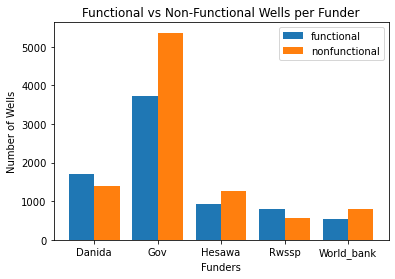

In [240]:
#Create double bar chart showing our top 5 fundrs impact on well functionality. Hard coded values. 
  
X = ['Danida','Gov','Hesawa','Rwssp', 'World_bank']
Yfunctional = [1713, 3720, 936, 805, 545]
Znonfunctional = [1401, 5364, 1266, 569, 804]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Yfunctional, 0.4, label = 'functional')
plt.bar(X_axis + 0.2, Znonfunctional, 0.4, label = 'nonfunctional')
  
plt.xticks(X_axis, X)
plt.xlabel("Funders")
plt.ylabel("Number of Wells")
plt.title("Functional vs Non-Functional Wells per Funder")
plt.legend()
plt.show()

In [241]:
#OneHotEncode Funder Column 
ohe = OneHotEncoder(sparse=False)
funder_df1 = pd.DataFrame(ohe.fit_transform(water_wells[['funder']]))
water_wells = pd.concat([water_wells, funder_df1], axis=1)
water_wells = water_wells.rename({0: 'funder_danida', 1: 'funder_gov', 2: 'funder_hesawa', 3: 'funder_rwssp', 4: 'funder_worldbank', 5: 'funder_other'}, axis=1)

In [242]:
water_wells.head()

,id,status_group,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,source_class,waterpoint_type_group,well_age,quantity_rank,funder_danida,funder_gov,funder_hesawa,funder_rwssp,funder_worldbank,funder_other
0,69572,1,6000.0,other,1390,Roman,34.938093,-9.856322,none,Lake Nyasa,...,groundwater,communal standpipe,22,4.0,0.0,0.0,0.0,0.0,0.0,1.0
1,8776,1,0.0,other,1399,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,...,surface,communal standpipe,11,3.0,0.0,0.0,0.0,0.0,0.0,1.0
2,34310,1,25.0,other,686,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,...,surface,communal standpipe,12,4.0,0.0,0.0,0.0,0.0,0.0,1.0
3,67743,0,0.0,other,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,...,groundwater,communal standpipe,35,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,19728,1,0.0,other,0,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,...,surface,communal standpipe,15,2.0,0.0,0.0,0.0,0.0,0.0,1.0


In [243]:
def installer_top_7(row):  
    '''Making top 7 values and setting the rest to 'other'''
    if row['installer']=='DWE':
        return 'DWE'
    elif row['installer']=='Government':
        return 'Government'
    elif row['installer']=='RWE':
        return 'RWE'
    elif row['installer']=='Commu':
        return 'Commu'
    elif row['installer']=='DANIDA':
        return 'DANIDA'
    elif row['installer']=='KKKT':
        return 'KKKT'
    elif row['installer']=='Hesawa':
        return 'Hesawa'
    else:
        return 'other'
    
water_wells['installer'] = water_wells.apply(lambda row: installer_top_7(row), axis=1)

In [244]:
water_wells.installer.value_counts()

other         35119
DWE           17402
Government     1825
RWE            1206
Commu          1060
DANIDA         1050
KKKT            898
Hesawa          840
Name: installer, dtype: int64

## Modeling

To make a simple model we are going to take the num cols and throw them into some simple classification models.

In [245]:
col_float = [c for c in water_wells.columns if water_wells[c].dtype == ('float64')]
col_int = [c for c in water_wells.columns if water_wells[c].dtype == ('int64')]
num_cols = col_float + col_int
num_cols

['amount_tsh',
 'longitude',
 'latitude',
 'permit',
 'quantity_rank',
 'funder_danida',
 'funder_gov',
 'funder_hesawa',
 'funder_rwssp',
 'funder_worldbank',
 'funder_other',
 'id',
 'status_group',
 'gps_height',
 'region_code',
 'population',
 'construction_year',
 'well_age']

In [246]:
#Create a holdout set to test at the end 
X = water_wells[num_cols].drop('status_group', axis=1)
y = water_wells['status_group']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)

### First Simple Model - Decision Tree

In [247]:
#perform a second train_test_split
X = X_train
y = y_train

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [248]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

##### Metrics for simple decison tree

In [249]:
# Check the accuracy score on our training data, using cross validation
cv = cross_val_score(dt, X_train, y_train)
cv

array([0.72452924, 0.72253398, 0.72203517, 0.72265869, 0.72602569])

In [250]:
#Average Cross Val Score 
avg_cv = cv.mean()
avg_cv

0.7235565531861828

In [251]:
dt_test_preds = dt.predict(X_test)
dt_train_preds = dt.predict(X_train)
print('test accuracy', accuracy_score(y_test, dt_test_preds))
print('test precision', precision_score(y_test, dt_test_preds))

print('train precision', precision_score(y_train, dt_train_preds))
print('train accuracy', accuracy_score(y_train, dt_train_preds))


test accuracy 0.7233819678264123
test precision 0.7425331858407079
train precision 1.0
train accuracy 1.0


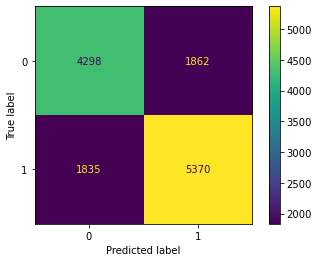

In [252]:
plot_confusion_matrix(dt, X_test, y_test)

##### Simple decision tree evaluation 


- Our first Decision tree is severely overfit, it scored 100 percent on training data and scored around 73 percent on test data
- I will tweak the max_depth in future decsion tree models

### Random Forest Model 

In [253]:
clf = RandomForestClassifier(max_depth=7)
clf.fit(X_train, y_train)
clf_test_preds = clf.predict(X_test)
clf_train_preds = clf.predict(X_train)

In [254]:
cross_val_score(clf, X_train, y_train)

array([0.72814565, 0.72452924, 0.72502806, 0.72427984, 0.72664921])

In [255]:
print('test precison score', precision_score(y_test, clf_test_preds))
print('test accuracy score', accuracy_score(y_test, clf_test_preds))

print('train precison score', precision_score(y_train, clf_train_preds))
print('train accuracy score', accuracy_score(y_train, clf_train_preds))

test precison score 0.6832819640769476
test accuracy score 0.7189674523007856
train precison score 0.6975783475783476
train accuracy score 0.7316124205013094


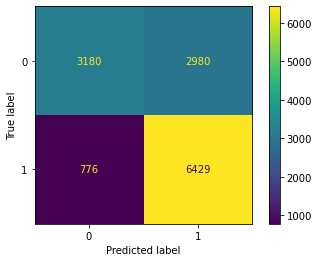

In [256]:
plot_confusion_matrix(clf, X_test, y_test)

##### Evaluation on Random Forest

- The model has 73% accuracy and 71% precision on unseen data, and seems to be slightly underfit since it performs better on unseen data.
- This model is an improvement over our last model since it does not overfit.
- The confusion matrix is showing 2956 false positives.

##### Simple Logistic Regression Model

In [257]:
logreg = LogisticRegression()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

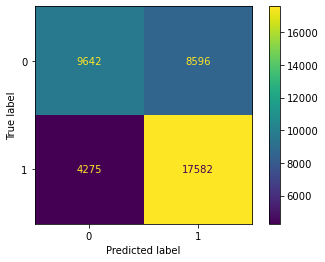

In [258]:
plot_confusion_matrix(logreg, X_train_scaled, y_train)

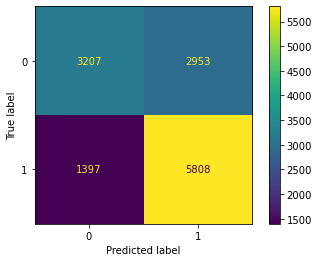

In [259]:
plot_confusion_matrix(logreg, X_test_scaled, y_test)

check metrics  for test and training data 

In [260]:
print(accuracy_score(y_train, logreg.predict(X_train_scaled)))
print(accuracy_score(y_test, logreg.predict(X_test_scaled)))

0.6789874049133309
0.6745230078563412


In [261]:
print(precision_score(y_train, logreg.predict(X_train_scaled)))
print(precision_score(y_test, logreg.predict(X_test_scaled)))

0.6716326686530675
0.6629380207738843


###### Evaluation on Logistic Regression metrics
- The Logistic model is performing worse than our 2 tree models on both unseen data and training data 
- The precison of our model is not high enough to consistently classify the actual functionality of water wells

In [262]:
# Use a function to evaluate models without repeating code
def evaluate(estimator, X_tr, X_te, y_tr, y_te, roc_auc='skip'):

    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': 
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba': 
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'")    
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
    if type(test_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_te, y_te, values_format='.5g')

###### Perform another train test split from the orginal dataframe but include more features to engineerand use in more complex models. Last time we only used numeric columns when we performed a train test split

In [263]:
water_wells.columns

Index(['id', 'status_group', 'amount_tsh', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'basin', 'region', 'region_code',
       'lga', 'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'permit', 'construction_year',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'quality_group', 'quantity', 'source', 'source_class',
       'waterpoint_type_group', 'well_age', 'quantity_rank', 'funder_danida',
       'funder_gov', 'funder_hesawa', 'funder_rwssp', 'funder_worldbank',
       'funder_other'],
      dtype='object')

In [264]:
used_cols = [c for c in water_wells.columns if c not in ['id', 'wpt_name', 'source_class_enc', 'funder', 'lga',
                                                        'quantity', 'ward', 'management_group', 'scheme_management',
                                                        'recorded_by', 'public_meeting', 'status_group', 'funder']]
used_cols


['amount_tsh',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'basin',
 'region',
 'region_code',
 'population',
 'permit',
 'construction_year',
 'extraction_type_class',
 'management',
 'payment_type',
 'quality_group',
 'source',
 'source_class',
 'waterpoint_type_group',
 'well_age',
 'quantity_rank',
 'funder_danida',
 'funder_gov',
 'funder_hesawa',
 'funder_rwssp',
 'funder_worldbank',
 'funder_other']

Create our holdout set which will be 15% of the data

In [265]:
X = water_wells[used_cols]
y = water_wells['status_group']

X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.15, random_state=42)

create a second split to train and test our data 

In [266]:
X = X_train
y= y_train

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Use a for loop to seperate our categorical columns from our numeric columns.

In [267]:
# Use a for loop to seperate numrical and categorical columns
num_cols =[]
cat_cols = []

for c in used_cols:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        cat_cols.append(c)

In [268]:
print(num_cols)
print(cat_cols)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'population', 'permit', 'construction_year', 'well_age', 'quantity_rank', 'funder_danida', 'funder_gov', 'funder_hesawa', 'funder_rwssp', 'funder_worldbank', 'funder_other']
['installer', 'basin', 'region', 'extraction_type_class', 'management', 'payment_type', 'quality_group', 'source', 'source_class', 'waterpoint_type_group']


In [269]:
# make sure there are no missing values before putting into our pipeline
X_train[cat_cols].isna().sum()

installer                0
basin                    0
region                   0
extraction_type_class    0
management               0
payment_type             0
quality_group            0
source                   0
source_class             0
waterpoint_type_group    0
dtype: int64

###### Construct a Pipeline

In [270]:
# Use one hot ecoder to encode all of our categorical data, and a robust scaler to scale numeric data incase we need use models
# that require normalization
hotencoder = OneHotEncoder(handle_unknown='ignore')
cat_transformer = make_pipeline(hotencoder)
scaler = RobustScaler()
num_transformer = make_pipeline(scaler)

In [271]:
preprocessor = ColumnTransformer(
    transformers=[('cat', cat_transformer, cat_cols), 
                  ('num', num_transformer, num_cols)], remainder='passthrough')

In [272]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['installer', 'basin', 'region',
                                  'extraction_type_class', 'management',
                                  'payment_type', 'quality_group', 'source',
                                  'source_class', 'waterpoint_type_group']),
                                ('num',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['amount_tsh', 'gps_height', 'longitude',
                                  'latitude', 'region_code', 'population',
                                  'permit', 'construction_year', 'well_age',
                                  'quantity_rank', 'funder_dan

In [273]:
X_tr_transformed = preprocessor.fit_transform(X_train)


After One Hot Encoding all of our categorical columns we now have 104 columns.

In [274]:
X_tr_transformed.shape

(37867, 104)

In [275]:
pd.DataFrame(X_tr_transformed).head()


,0
0,"(0, 2)\t1.0\n (0, 11)\t1.0\n (0, 21)\t1.0\..."
1,"(0, 2)\t1.0\n (0, 9)\t1.0\n (0, 33)\t1.0\n..."
2,"(0, 7)\t1.0\n (0, 8)\t1.0\n (0, 17)\t1.0\n..."
3,"(0, 7)\t1.0\n (0, 15)\t1.0\n (0, 29)\t1.0\..."
4,"(0, 2)\t1.0\n (0, 14)\t1.0\n (0, 20)\t1.0\..."


In [276]:

rfc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_depth =9))
])

In [277]:
cross_val_score(rfc, X_train, y_train)


array([0.75099023, 0.7702667 , 0.75557903, 0.76310577, 0.76336987])

In [278]:
cross_validate(rfc, X_train, y_train, return_train_score=True)

{'fit_time': array([5.56252885, 5.6907711 , 5.72383451, 5.72520304, 5.62446404]),
 'score_time': array([0.13503098, 0.14866996, 0.13904643, 0.14204812, 0.13970494]),
 'test_score': array([0.74861368, 0.76921046, 0.75835204, 0.76270963, 0.76508649]),
 'train_score': array([0.77740732, 0.77361107, 0.77490592, 0.77411369, 0.77371757])}

In [279]:
cross_validate(rfc, X_train, y_train, scoring='precision', return_train_score=True)

{'fit_time': array([5.52685118, 5.65830421, 5.83067584, 5.97821164, 5.77086115]),
 'score_time': array([0.14010334, 0.14404798, 0.14202285, 0.14102006, 0.13603997]),
 'test_score': array([0.7079479 , 0.72888629, 0.71865385, 0.72179732, 0.71999243]),
 'train_score': array([0.72972716, 0.72891856, 0.73037787, 0.72799354, 0.72793414])}

In [280]:
rfc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['installer', 'basin',
                                                   'region',
                                                   'extraction_type_class',
                                                   'management', 'payment_type',
                                                   'quality_group', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('robustscaler',
  

Training Scores:
Train Accuracy: 0.7724403834473288
Train Precision: 0.728316816470769
Train Recall: 0.9247012923677151
Train F1-Score: 0.8148434646210705
ROC-AUC: 0.8616480478335574
**********
Testing Scores:
Test Accuracy: 0.7605957379386834
Test Precision: 0.7235949890817147
Test Recall: 0.910747866338782
Test F1-Score: 0.8064557448443704
ROC-AUC: 0.8458840966396721


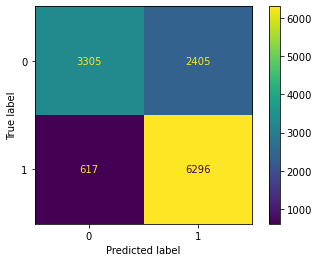

In [281]:
evaluate(rfc, X_train, X_test, y_train, y_test, roc_auc='proba')


##### Random Forest evaluation

- This random model is performing better than our first random forest model.
- Our first simple random forest model had an accuracy score of 73% and a precision score of 71% on unseen data, while this model has an accuracy score of 76% on unseen data and a precision score of 72% on unseen data.
- We have a ROC_AUC score of 84 on unseen data meaning that our model is pretty good overall at correctly classifying well functionallity.
- This model has similar scores for both seen and unseen data, so using a max_depth of 9 seems to be working for our random forest models.


In [282]:
xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(max_depth =9))
])

In [283]:
cross_val_score(xgb, X_train, y_train)

array([0.80076578, 0.81264853, 0.81486861, 0.80628549, 0.80958669])

In [284]:
cross_validate(xgb, X_train, y_train, return_train_score=True)

{'fit_time': array([2.70671415, 2.60061097, 1.80285835, 1.78006482, 1.73582864]),
 'score_time': array([0.11802697, 0.1080246 , 0.11102581, 0.10655165, 0.10902476]),
 'test_score': array([0.80076578, 0.81264853, 0.81486861, 0.80628549, 0.80958669]),
 'train_score': array([0.92130195, 0.92047668, 0.92094144, 0.91377831, 0.91925794])}

In [285]:
xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['installer', 'basin',
                                                   'region',
                                                   'extraction_type_class',
                                                   'management', 'payment_type',
                                                   'quality_group', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('robusts...
      

Training Scores:
Train Accuracy: 0.9113476113766604
Train Precision: 0.8873678503659528
Train Recall: 0.9578639356254572
Train F1-Score: 0.9212692605361289
ROC-AUC: 0.9744629759667351
**********
Testing Scores:
Test Accuracy: 0.812722807573477
Test Precision: 0.8050972501676728
Test Recall: 0.8682192969767105
Test F1-Score: 0.8354677060133631
ROC-AUC: 0.8908393359246254


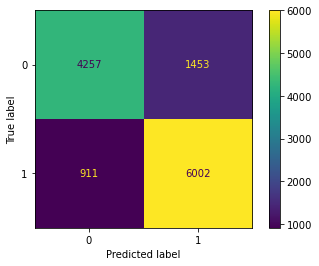

In [286]:
evaluate(xgb, X_train, X_test, y_train, y_test, roc_auc='proba')


##### XGB evaluation
- Both test accuracy and test precision went up but our model is overfitting, the accuracy for this model is almost .10 hihger on the training data than it is on seen data.  
- and the ROC-AUC is 89 in this model meaning that our model is really good at correctly classifying well functionality.
- A max_depth of 9 for XGB models seems to be too high and is probably the cause of the overfitting, perhaps lowering that and tweaking the learning rate might help. 

Now we will tune our XGB model 

In [287]:
xgb_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(max_depth=6, learning_rate =.2 ))
])

In [288]:
cross_val_score(xgb_tuned, X_train, y_train)

array([0.79073145, 0.80367045, 0.79928694, 0.79902284, 0.80536115])

In [289]:
cross_validate(xgb_tuned, X_train, y_train, scoring='precision', return_train_score=True)

{'fit_time': array([1.89573312, 1.91303825, 1.38368893, 1.3616302 , 1.31768894]),
 'score_time': array([0.11311364, 0.12102723, 0.11653352, 0.11810493, 0.11902452]),
 'test_score': array([0.76937901, 0.78599562, 0.77687192, 0.77977869, 0.77810714]),
 'train_score': array([0.81634195, 0.81328652, 0.81099989, 0.81540879, 0.80986672])}

In [290]:
xgb_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['installer', 'basin',
                                                   'region',
                                                   'extraction_type_class',
                                                   'management', 'payment_type',
                                                   'quality_group', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('robusts...
      

Training Scores:
Train Accuracy: 0.8405207700636438
Train Precision: 0.8136328158876073
Train Recall: 0.9150938795415752
Train F1-Score: 0.8613859113549245
ROC-AUC: 0.9216620332009009
**********
Testing Scores:
Test Accuracy: 0.8036124534579735
Test Precision: 0.7891236306729265
Test Recall: 0.8753073918703891
Test F1-Score: 0.8299842260475961
ROC-AUC: 0.8829047052901422


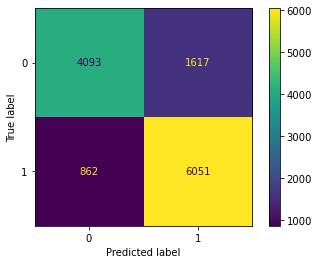

In [291]:
evaluate(xgb_tuned, X_train, X_test, y_train, y_test, roc_auc='proba')


##### Tuned XGB model Evaluation
- lowering the max depth from 9 to 6 and lowerring the learning rate to .2 seems to have made our model less overfit. The training data only did about 3.5 points better on training data.
- A precision score of 78% and an accuracy score of 80% is pretty good.
- ROC_AUC score of 88 is imppresive

In [292]:
xgb_tuned_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(max_depth=6, n_estimators= 500, learning_rate=.03))
])

In [293]:
cross_validate(xgb_tuned_2, X_train, y_train, scoring='precision', return_train_score=True)

{'fit_time': array([8.06023645, 7.84639359, 5.03545356, 5.01328397, 5.03238606]),
 'score_time': array([0.13302994, 0.13202882, 0.12814403, 0.13253856, 0.13178968]),
 'test_score': array([0.76306914, 0.78133103, 0.77484009, 0.76908356, 0.77173913]),
 'train_score': array([0.8015932 , 0.7993707 , 0.80032959, 0.79945828, 0.79777494])}

In [294]:
xgb_tuned_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['installer', 'basin',
                                                   'region',
                                                   'extraction_type_class',
                                                   'management', 'payment_type',
                                                   'quality_group', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('robusts...
      

Training Scores:
Train Accuracy: 0.8280296828372989
Train Precision: 0.7976094261772088
Train Recall: 0.9144598878322361
Train F1-Score: 0.8520470759303859
ROC-AUC: 0.9116362742154448
**********
Testing Scores:
Test Accuracy: 0.7993345480472154
Test Precision: 0.7787678207739308
Test Recall: 0.8849992767250109
Test F1-Score: 0.8284921118559143
ROC-AUC: 0.8801763245622415


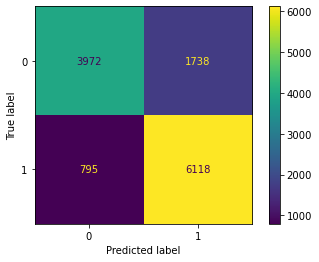

In [295]:
evaluate(xgb_tuned_2, X_train, X_test, y_train, y_test, roc_auc='proba')


##### Evaluate our tuned model

- This model is slightly overfit but not that much. 
- Scored around 79% on both accuracy and precision on testing data.
- An ROC_AUC score of 87 meand that the model is doing pretty good at classifying well functionality.
- Has potential to be final model. 

### knn modeling

In [296]:
knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [297]:
cross_validate(knn, X_train, y_train, scoring='precision', return_train_score=True)

{'fit_time': array([0.15303493, 0.16504002, 0.14411688, 0.13006663, 0.12774253]),
 'score_time': array([14.0485208 , 14.01018929, 11.4021318 , 11.604774  , 11.44606948]),
 'test_score': array([0.77101516, 0.7906062 , 0.78143852, 0.77643298, 0.77238138]),
 'train_score': array([0.8433193 , 0.8378394 , 0.8395246 , 0.84111988, 0.83686805])}

In [298]:
knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['installer', 'basin',
                                                   'region',
                                                   'extraction_type_class',
                                                   'management', 'payment_type',
                                                   'quality_group', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('robustscaler',
  

Training Scores:
Train Accuracy: 0.851797079251063
Train Precision: 0.8432990641279794
Train Recall: 0.8920751036332601
Train F1-Score: 0.867001611527159
ROC-AUC: 0.9367203882409209
**********
Testing Scores:
Test Accuracy: 0.7863423908738018
Test Precision: 0.7886880306765269
Test Recall: 0.833068132503978
Test F1-Score: 0.8102708406612733
ROC-AUC: 0.8563197513859393


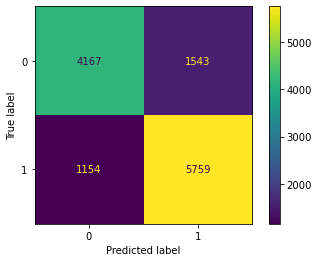

In [299]:
evaluate(knn, X_train, X_test, y_train, y_test, roc_auc='proba')

##### First knn neighbors model review
- Model is overfit, but has pretty good accuracy and precision scores
- Our confusion matrix does not have too many false positives which is important.

##### Attempt a grid seaarch on our knn hyper parameters

In [300]:
knn.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__cat', 'preprocessor__num', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__onehotencoder', 'preprocessor__cat__onehotencoder__categories', 'preprocessor__cat__onehotencoder__drop', 'preprocessor__cat__onehotencoder__dtype', 'preprocessor__cat__onehotencoder__handle_unknown', 'preprocessor__cat__onehotencoder__sparse', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__robustscaler', 'preprocessor__num__robustscaler__copy', 'preprocessor__num__robustscaler__quantile_range', 'preprocessor__num__robustscaler__with_centering', 'preprocessor__num__robustscaler__with_scaling', 'classifier__algorithm', 'classifier__leaf_s

In [301]:
# param_grid = {
#     "classifier__n_neighbors": [3, 5, 11, 19],
#     "classifier__weights": ['uniform', 'distance'],
#     "classifier__metric": ['euclidean', 'manhattan']
# }

# grid_search = GridSearchCV(knn, param_grid, verbose=1, cv=3, n_jobs=-1)
# grid_search.fit(X_train, y_train)

In [302]:
#grid_search.best_score_

In [303]:
#grid_search.best_params_

In [304]:
knn_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=19, weights='distance', metric='manhattan'))
])

In [305]:
knn_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['installer', 'basin',
                                                   'region',
                                                   'extraction_type_class',
                                                   'management', 'payment_type',
                                                   'quality_group', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('robustscaler',
  

In [306]:
cross_validate(knn, X_train, y_train, scoring='precision', return_train_score=True)

{'fit_time': array([0.14508438, 0.12398076, 0.14846039, 0.12602925, 0.12405276]),
 'score_time': array([11.41009307, 10.80377078, 11.32134056, 10.98823786, 11.5550189 ]),
 'test_score': array([0.77101516, 0.7906062 , 0.78143852, 0.77643298, 0.77238138]),
 'train_score': array([0.8433193 , 0.8378394 , 0.8395246 , 0.84111988, 0.83686805])}

Training Scores:
Train Accuracy: 0.99574827686376
Train Precision: 0.9962435359547273
Train Recall: 0.9959034381858083
Train F1-Score: 0.9960734580396555
ROC-AUC: 0.9998910782322444
**********
Testing Scores:
Test Accuracy: 0.7971955953418364
Test Precision: 0.7960821656917426
Test Recall: 0.8465210473021842
Test F1-Score: 0.8205272013460461
ROC-AUC: 0.8725742104205813


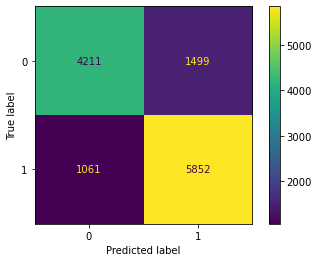

In [307]:
evaluate(knn_tuned, X_train, X_test, y_train, y_test, roc_auc='proba')

#### knn grid serach evaluation
- Grid Serach caused our model to severly overfit on the training data.
- The model performs similarly to our last xgb_tuned_2 model but is alot more overfit.
- Our xgb_tuned_2_model has the best chance of performing well on unseen data.

## Final Model Evaluation
We will use the same parameters that we used on our xgb_tuned_2 model, because that one gave us the the best results on precision without overfitting.

In [312]:
y_hold.shape

(8910,)

In [308]:
xgb_tuned_2_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(max_depth=6, n_estimators= 500, learning_rate=.03))
])

In [309]:
xgb_tuned_2_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['installer', 'basin',
                                                   'region',
                                                   'extraction_type_class',
                                                   'management', 'payment_type',
                                                   'quality_group', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('robusts...
      

Training Scores:
Train Accuracy: 0.8280296828372989
Train Precision: 0.7976094261772088
Train Recall: 0.9144598878322361
Train F1-Score: 0.8520470759303859
ROC-AUC: 0.9116362742154448
**********
Testing Scores:
Test Accuracy: 0.7973063973063973
Test Precision: 0.7742635098499909
Test Recall: 0.8849411278661433
Test F1-Score: 0.8259109311740891
ROC-AUC: 0.8801763245622415


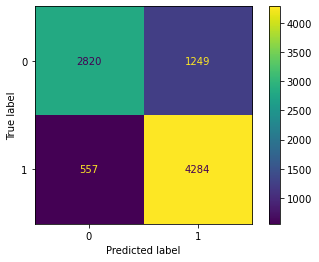

In [310]:
evaluate(xgb_tuned_2_final, X_train, X_hold, y_train, y_hold, roc_auc='proba')


### Final Model Evaluation
- This model is slightly overfit on the training data but performs good on our unseen holdout data. 
- Out of 8910 predictions it only classified 1249 wells as functional when they were not.
- A precision score of 77 percent on means that we have a pretty low false positive rate.

## Conclusions



- We reccommend that you use this model in conjuction with your own resources to identify faulty wells.
- Our model will still classify some non functional wells as functional 20% of the time so further investigation will be needed at times. 


#### Future work
- Further engineer more features to give our model better data to make predictions off of.
- Further tune hyperparameters to optomize our models performance on unseen data.